# [Scene Recognition with Deep Learning](https://dellaert.github.io/19F-4476/proj6.html)
Remember in the previous project, where you have tried with a bunch of old-school techniques for image classification on the 15-scene data? Well for this project we are going to focus on the same task, but with the state-of-the-art approach: deep learning.

Basic learning objectives of this project:
1. Construct the fundamental pipeline for performing deep learning using PyTorch;
2. Understand the concepts behind different layers, optimizers, and learning schedules;
3. Experiment with different models and observe the performance.

The starter code is mostly initialized to 'placeholder' just so that the starter
code does not crash when run unmodified and you can get a preview of how
results are presented.

In [6]:
import sys
sys.path.append("../")
from proj4_code.runner import Trainer
from proj4_code.optimizer import get_optimizer
from proj4_code.simple_net import SimpleNet
from proj4_code.simple_net_dropout import SimpleNetDropout
from proj4_code.my_alexnet import MyAlexNet
from proj4_code.image_loader import ImageLoader
from proj4_code.data_transforms import get_fundamental_transforms, get_data_augmentation_transforms
from proj4_code.stats_helper import compute_mean_and_std

import torch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from proj4_unit_tests.test_base import verify
from proj4_unit_tests.test_stats_helper import test_mean_and_variance
from proj4_unit_tests.test_image_loader import test_dataset_length, test_unique_vals, test_class_values, test_load_img_from_path
from proj4_unit_tests.test_data_transforms import test_fundamental_transforms
from proj4_unit_tests.test_dl_utils import test_predict_labels, test_compute_loss
from proj4_unit_tests.test_simple_net import test_simple_net
from proj4_unit_tests.test_simple_net_dropout import test_simple_net_dropout
from proj4_unit_tests.test_my_alexnet import test_my_alexnet

In [8]:
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available() # will turn off cuda if the machine doesnt have a GPU

## Part 1: Train a SimpleNet
To train a network in PyTorch, we need 4 components:
1. **Dataset** - an object which can load the data and labels given an index.
2. **Model** - an object that contains the network architecture definition.
3. **Loss function** - a function that measures how far the network output is from the ground truth label.
4. **Optimizer** - an object that optimizes the network parameters to reduce the loss value.

### Part 1.1: Datasets
One crucial aspect of deep learning is to perform data preprocessing. In this project we are going to "zero-center" and "normalize" the dataset. 

### Compute mean and standard deviation of the dataset
To begin with, fill in the `compute_mean_and_std()` in `stats_helper.py` to compute the **mean** and **standard deviation** of both training and validation data.

In [4]:
print("Testing your mean and std computation: ", verify(test_mean_and_variance))
dataset_mean, dataset_std = compute_mean_and_std('../data/')

Testing your mean and std computation:  "Correct"


In [5]:
print('Dataset mean = {}, standard deviation = {}'.format(dataset_mean, dataset_std))

Dataset mean = [0.45547486], standard deviation = [0.25316328]


Now let's create the **Datasets** object to be used later. Remember back in Project 1, we have initialized such a class to load 5 images? Here the task is similar: download the data into the project folder, and then complete the `image_loader.py`. The essence is to retrieve the paths to all the images required, and be able to provide the **path** and the **class id** when given an index.

In [6]:
inp_size = (64,64)
print("Testing your image loader (length):", verify(test_dataset_length))
print("Testing your image loader (values):", verify(test_unique_vals))
print("Testing your image loader (classes):", verify(test_class_values))
print("Testing your image loader (paths):", verify(test_load_img_from_path))

Testing your image loader (length): "Correct"
Testing your image loader (values): "Correct"
Testing your image loader (classes): "Correct"
Testing your image loader (paths): "Correct"


### Data transforms
For this part, complete the function `get_fundamental_transforms()` in `data_transforms.py` to compile a list of fundamental transforms which:
1. Resize the input image to the desired shape;
2. Convert it to a tensor;
3. Normalize them based on the computed mean and standard deviation.

In [7]:
print("Testing your fundamental data transforms: ", verify(test_fundamental_transforms))

Testing your fundamental data transforms:  "Correct"


/data/lilinwei/CVexp/proj4/proj4_code/../proj4_unit_tests/test_data_transforms.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  expected_output = torch.load('../proj4_un

### Part 1.2: Model
The data is ready! Now we are preparing to move to the actual core of deep learning: the architecture. To get you started in this part, simply define a **2-layer** model in the `simple_net.py`. Here by "2 layers" we mean **2 convolutional layers**, so you need to figure out the supporting utilities like ReLU, Max Pooling, and Fully Connected layers, and configure them with proper parameters to make the tensor flow.

You may refer to the project [instruction page](https://dellaert.github.io/19F-4476/proj6.html) for a sample network architecture (it's the architecture TAs used in their implementation and is sufficient to get you pass Part 1).

In [5]:
print("Testing your SimpleNet architecture: ", verify(test_simple_net))

Testing your SimpleNet architecture:  "Correct"


In [9]:
simple_model = SimpleNet()

### Loss function
When defining your model architecture, also initialize the `loss_criterion` variable there. Remeber this is multi-class classification problem, and think about what loss function might be useful here.

In [10]:
print(simple_model)

SimpleNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=15, bias=True)
  )
  (loss_criterion): CrossEntropyLoss()
)


### Optimizer
Next, **initialize the following cell with proper values for learning rate and weight decay** (you can come back and tune these values for better performance once the trainer section is done), and then fill in the `optimizer.py` to initialize a basic optimization function; this should only take a few lines of code.

In [11]:
# TODO: add a decent initial setting and tune from there
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 1e-3,
  "weight_decay": 1e-4
}

In [12]:
optimizer = get_optimizer(simple_model, optimizer_config)

optimizer is: adam
learning rate is: 0.001
weight decay is: 0.0001


### Part 1.3: Trainer
Next we define the trainer for the model; to start, complete the `predict_labels()` and `compute_loss()` in `dl_utils.py`: given a model, compute the corresponding predictions and loss respectively.

In [13]:
print("Testing your trainer (model prediction): ", verify(test_predict_labels))
print("Testing your trainer (loss values): ", verify(test_compute_loss))

Testing your trainer (model prediction):  "Correct"
Testing your trainer (loss values):  "Correct"


Then pass in the model, optimizer, transforms for both the training and testing datasets into the trainer, and proceed to the next cell to train it. If you have implemented everything correctly, you should be seeing a decreasing loss value.

**Note** that your CPU should be sufficient to handle the training process for all networks in this project, and the following training cells will take less than 5 minutes; you may also want to decrease the value for `num_epochs` and quickly experiment with your parameters. The default value of **30** is good enough to get you around the threshold for Part 1, and you are free to increase it a bit and adjust other parameters in this part.

In [14]:
trainer = Trainer(data_dir='../data/', 
                  model = simple_model,
                  optimizer = optimizer,
                  model_dir = 'model_checkpoints/simple_net',
                  train_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

In [15]:
trainer.train(num_epochs=30)

Epoch:1, Loss:1.9293
Epoch:2, Loss:1.5888
Epoch:3, Loss:1.5389
Epoch:4, Loss:1.5981
Epoch:5, Loss:1.1458
Epoch:6, Loss:1.1769
Epoch:7, Loss:1.0027
Epoch:8, Loss:1.0371
Epoch:9, Loss:0.5632
Epoch:10, Loss:1.0970
Epoch:11, Loss:0.1079
Epoch:12, Loss:0.0104
Epoch:13, Loss:0.0946
Epoch:14, Loss:0.0120
Epoch:15, Loss:0.1477
Epoch:16, Loss:0.1603
Epoch:17, Loss:0.0050
Epoch:18, Loss:0.0046
Epoch:19, Loss:0.0009
Epoch:20, Loss:0.0020
Epoch:21, Loss:0.0027
Epoch:22, Loss:0.0018
Epoch:23, Loss:0.0031
Epoch:24, Loss:0.0009
Epoch:25, Loss:0.0009
Epoch:26, Loss:0.0058
Epoch:27, Loss:0.0021
Epoch:28, Loss:0.0005
Epoch:29, Loss:0.0008
Epoch:30, Loss:0.0004


After you have finished the training process, now plot out the loss and accuracy history. You can also check out the final accuracy for both training and testing data. Copy the accuracy plots and values onto the report, and answer the questions there. Note that you are required to obtain a **50%** testing accuracy to receive full credits for Part 1.

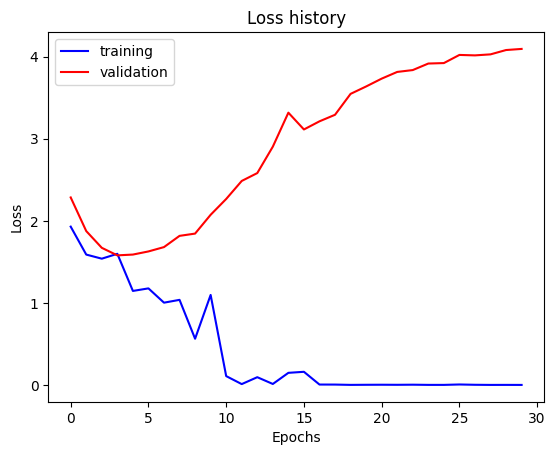

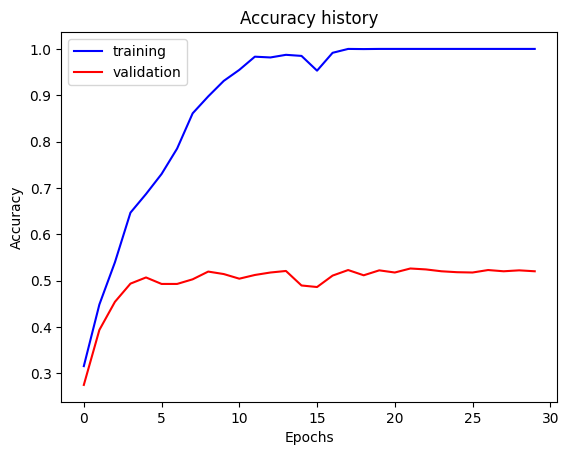

In [16]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [17]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {}; Validation Accuracy = {}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 1.0; Validation Accuracy = 0.52


## Part 2: Overfitting
Feeling good? We have easily obtained a 50% accuracy on the testing data with a very simple model; this is already the highest standard for the previous project. Feeling even better for the training accuracy right? More than 90% (if you have implemented everything correctly). But should you?

Our final accuracies for training and testing data differ a lot from each other, which indicates that the model we have defined **fits too well with the training data, but is unable to generalize well on data it has never seen before**: this is often regarded as **overfitting**. In this section we are going to apply 2 techniques to tackle with it: adjusting both data and model.

### Part 2.1: Jitter, Random Flip, and Normalization
One common technique to increase the "variability" of the data is to **augment** it. Firstly, we don't have a huge amount of data, so let's "jitter" based on it; secondly, when you mirror an image of a **kitchen**, you can tell that the mirrored image is still a kitchen. Hence, finsih the `get_data_augmentation_transforms()` function in `data_transforms.py`: you may first copy your existing fundamental transform implementation into this function, and then insert a couple of other transforms which help you do the above adjustment.

In [18]:
inp_size = (64,64)

### Part 2.2: Dropout
"Dropout" is a technique commonly used to regularize the network. It randomly turns off the connection between neurons inside the network and prevent the network from relying too much on a specific neuron. Follow the instruction and finish the `simple_net_dropout.py` with your previous SimpleNet model, plus the dropout layer, and lastly re-run the training process as below.

In [4]:
from proj4_unit_tests.test_base import verify
from proj4_unit_tests.test_simple_net_dropout import test_simple_net_dropout

In [10]:
print("Testing your SimpleNetDropout architecture: ", verify(test_simple_net_dropout))

Testing your SimpleNetDropout architecture:  "Correct"


In [9]:
simple_model_dropout = SimpleNetDropout()
print(simple_model_dropout)

SimpleNetDropout(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=15, bias=True)
  )
  (loss_criterion): CrossEntropyLoss()
)


Similar to the previous part, **initialize the following cell with proper values for learning rate and weight decay**.

In [11]:
# TODO: add a decent initial setting and tune from there
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 1e-3,
  "weight_decay": 1e-4
}

In [12]:
optimizer = get_optimizer(simple_model_dropout, optimizer_config)

optimizer is: adam
learning rate is: 0.001
weight decay is: 0.0001


In [14]:
inp_size = (64, 64) 

In [16]:
trainer = Trainer(data_dir='../data/', 
                  model = simple_model_dropout,
                  optimizer = optimizer,
                  model_dir = '../model_checkpoints/simple_net_dropout',
                  train_data_transforms = get_data_augmentation_transforms(inp_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

The following cell will take longer than Part 1, as now we have more data (and more variability), and the model is slightly more complicated than before as well; however, it should finish within 10~15 minutes anyway, and the default `num_epochs` is also good enough as a starting point for you to pass this part.

In [17]:
trainer.train(num_epochs=30)

Epoch:1, Loss:2.7015
Epoch:2, Loss:2.7598
Epoch:3, Loss:2.1724
Epoch:4, Loss:2.1711
Epoch:5, Loss:1.7217
Epoch:6, Loss:2.5419
Epoch:7, Loss:1.8139
Epoch:8, Loss:1.8002
Epoch:9, Loss:1.5264
Epoch:10, Loss:1.9024
Epoch:11, Loss:1.2067
Epoch:12, Loss:1.7526
Epoch:13, Loss:1.9219
Epoch:14, Loss:1.5690
Epoch:15, Loss:1.8516
Epoch:16, Loss:1.9754
Epoch:17, Loss:1.3003
Epoch:18, Loss:1.7858
Epoch:19, Loss:1.4366
Epoch:20, Loss:1.4442
Epoch:21, Loss:1.7441
Epoch:22, Loss:1.3148
Epoch:23, Loss:1.7138
Epoch:24, Loss:1.5333
Epoch:25, Loss:0.5854
Epoch:26, Loss:1.5188
Epoch:27, Loss:1.4388
Epoch:28, Loss:1.4173
Epoch:29, Loss:0.8608
Epoch:30, Loss:1.3883


Similar to the previous part, now plot out the loss and accuracy history. You'll need to pass a threshold of **55%** to receive full credits for this part. Also copy the plots onto the report, and answer the questions accordingly.

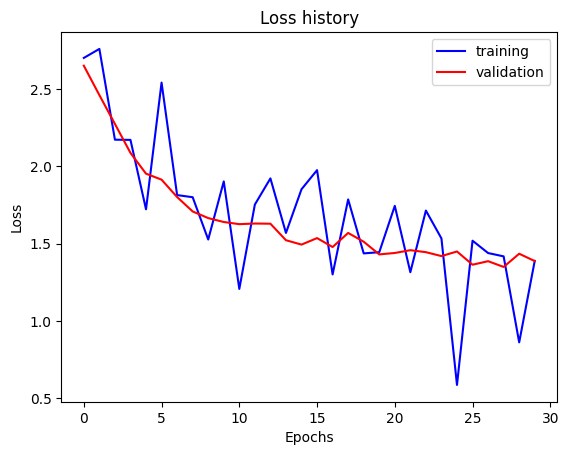

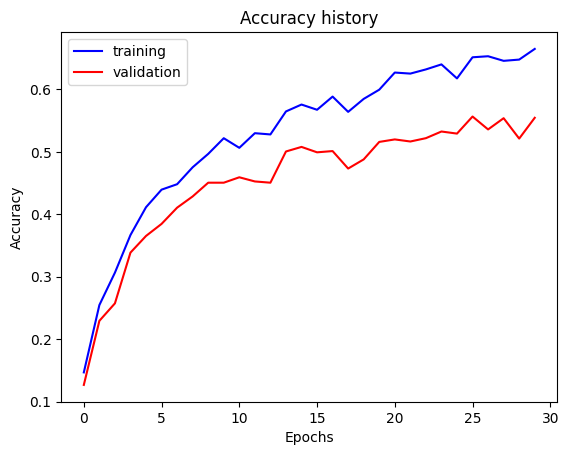

In [18]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [19]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {}; Validation Accuracy = {}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 0.6649916247906198; Validation Accuracy = 0.5546666666666666


## Part 3: AlexNet
You can see that after the above adjustment, our model performance increases in terms of testing accuracy. Although the training accuracy drops, now it's closer to the testing values and that's more natural in terms of performance. But we are not satisfied with the final performance yet. Our model, in the end, is still a 2-layer SimpleNet and it might be capable of capturing some features, but could be improved a lot if we go **deeper**. In this part we are going to see the power of a famous model: AlexNet.

In [20]:
inp_size = (224, 224)

### Part 3.1 & 3.2: Fine-tuning the AlexNet
Now switch to `my_alexnet.py`, and define a AlexNet which can be fit onto our dataset: PyTorch has provided us with pre-trained models like AlexNet, so what you want to do is to load the model first, and then adjust some of the layers such that it fits with our own dataset, instead of outputing scores to 1000 classes from the original AlexNet model.

After you have defined the correct architecture of the model, make some tweaks to the existing layers: **freeze** the **convolutional** layers and first 2 **linear** layers so we don't update the weights of them; more details can be found in the instruction webpage.

In [25]:
print("Testing your AlexNet architecture: ", verify(test_my_alexnet))

Testing your AlexNet architecture:  "Correct"


In [26]:
my_alexnet = MyAlexNet()
print(my_alexnet)

MyAlexNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True

In [27]:
# TODO: add a decent initial setting and tune from there
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 1e-3,
  "weight_decay": 1e-4
}

In [28]:
optimizer = get_optimizer(my_alexnet, optimizer_config)

optimizer is: adam
learning rate is: 0.001
weight decay is: 0.0001


In [30]:
trainer = Trainer(data_dir='../data/', 
                  model = my_alexnet,
                  optimizer = optimizer,
                  model_dir = '../model_checkpoints/myalexnet/',
                  train_data_transforms = get_data_augmentation_transforms(inp_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

The following training cell will take roughly 20 minutes or slightly more using CPU (but possibly under 5 minute using GPU depending on the batch size; the TAs got it within 3 minutes on a GTX1060).

In [31]:
trainer.train(num_epochs=5)

Epoch:1, Loss:0.8659
Epoch:2, Loss:0.1218
Epoch:3, Loss:0.5839
Epoch:4, Loss:0.3883
Epoch:5, Loss:0.3904


Like both previous sections, you are required to pass a threshold of **85%** for this part. Copy the plots and values onto the report and answer questions accordingly.

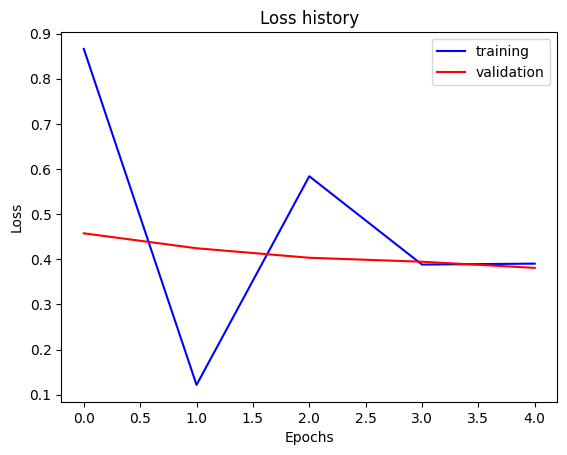

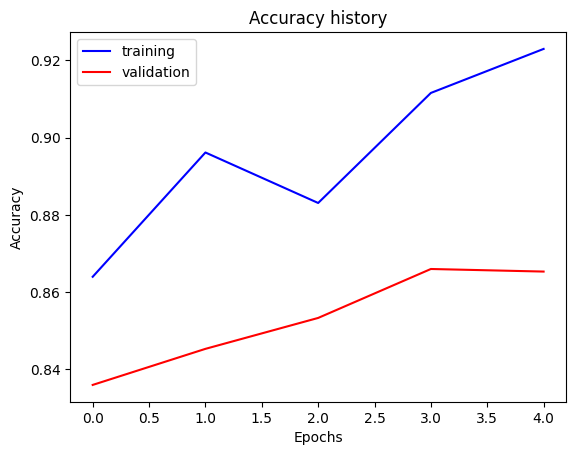

In [32]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [33]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {}; Validation Accuracy = {}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 0.9229480737018425; Validation Accuracy = 0.8653333333333333


With all these we have concluded the last project of CS4476 Computer Vision. Things might be hard along the way, but we hope you enjoyed this journey and have learnt something in this field. Our team has learnt a lot from you guys as well, so thank you and wish you all the best in your future endeavors!